In [1]:
from data_manager import DataManager
import pickle
import numpy as np
input_files = ["X00_COUNTS.csv", "X01_AGE_AND_SEX.csv", "X02_RACE.csv", "X03_HISPANIC_OR_LATINO_ORIGIN.csv", "X07_MIGRATION.csv", 
         "X08_COMMUTING.csv", "X12_MARITAL_STATUS_AND_HISTORY.csv", "X16_LANGUAGE_SPOKEN_AT_HOME.csv",
         "X15_EDUCATIONAL_ATTAINMENT.csv"]
input_DM = DataManager(filenames=input_files)
_,_ = input_DM.import_all()

count_files = ["X00_COUNTS_1col.csv"]
count_DM = DataManager(filenames=count_files)
_,_ = count_DM.import_all()


['X00_COUNTS.csv', 'X01_AGE_AND_SEX.csv', 'X02_RACE.csv', 'X03_HISPANIC_OR_LATINO_ORIGIN.csv', 'X07_MIGRATION.csv', 'X08_COMMUTING.csv', 'X12_MARITAL_STATUS_AND_HISTORY.csv', 'X16_LANGUAGE_SPOKEN_AT_HOME.csv', 'X15_EDUCATIONAL_ATTAINMENT.csv']
X00_COUNTS.csv
X01_AGE_AND_SEX.csv
X02_RACE.csv
X03_HISPANIC_OR_LATINO_ORIGIN.csv
X07_MIGRATION.csv
X08_COMMUTING.csv
X12_MARITAL_STATUS_AND_HISTORY.csv
X16_LANGUAGE_SPOKEN_AT_HOME.csv
X15_EDUCATIONAL_ATTAINMENT.csv
18998
18998
18998
18998
18998
18998
18998
18998
18998
all headers
['X00_COUNTS_1col.csv']
X00_COUNTS_1col.csv
18998
all headers


In [2]:

print(input_DM.data.shape)
print(count_DM.data.shape)

input_DM.data = np.divide(input_DM.data,count_DM.data)
print(len(input_DM.data[0]))
print('hello')


(18998, 1572)
(18998, 1)
1572
hello


/vol/biomedic/users/kgs13/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/vol/biomedic/users/kgs13/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [3]:
output_files = ["X19_INCOME_median.csv"]
output_DM = DataManager(filenames=output_files)
_,_ = output_DM.import_all()
print(len(output_DM.data[0]))

['X19_INCOME_median.csv']
X19_INCOME_median.csv
18998
all headers
2


In [4]:
tmp_end = output_DM.data[:, 0]
tmp_keep_idx = np.where(tmp_end!=0.)[0] # gives np array of indices
output_DM.data = output_DM.data[tmp_keep_idx,:]
input_DM.data = input_DM.data[tmp_keep_idx,:]

In [5]:
import sklearn
from sklearn.decomposition import PCA
import random
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt

def return_folds(m,n): # m samples, n folds
    testing_number = np.int(np.divide(np.float(m), np.float(n)))
    l = list(range(m))
    random.shuffle(l)
    test_indices = [] # indices to be used as testing
    train_indices = []
    for i in list(range(n)):
        test_indices.append(l[testing_number*i:(testing_number*(i+1))])
        this_train = l[0:testing_number*i] + l[testing_number*(i+1)::]
        train_indices.append(this_train)
    return train_indices, test_indices
    

def one_fold(train_data, train_labels, test_data, test_labels, name="__dev_"):
    N_dim = 410
    pca = PCA(n_components=N_dim) # 1568 = number in data
    model_mean = train_data.mean(axis=0)
    model_std = train_data.std(axis=0)
    normalised_data = (train_data - model_mean) / model_std
    nan_mask = np.isnan(normalised_data)
    normalised_data[nan_mask] = 0.
    print(np.sum(np.isnan(normalised_data)))

    pca.fit(normalised_data)
    print(pca.explained_variance_ratio_)
    print(pca.singular_values_)
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(np.cumsum(pca.explained_variance_ratio_)*100.)
    plt.show()
    fig.savefig(name+'PCA_Variance.png')
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(np.cumsum(pca.explained_variance_ratio_[0:500])*100.)
    plt.show()
    fig.savefig(name+'PCA_Variance_2.png')
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(np.cumsum(pca.explained_variance_ratio_[0:500])*100.)
    plt.yscale('log')
    plt.show()
    fig.savefig(name+'PCA_Variance_3.png')
    
    print("PCA finished for " + name)
    
    reg = linear_model.LinearRegression()
    reg.fit(pca.transform(normalised_data), train_labels)
    print(train_data.shape)
    print(train_labels.shape)
    
    test_normalised_data = (test_data - model_mean) / model_std
    nan_mask = np.isnan(test_normalised_data)
    test_normalised_data[nan_mask] = 0.
    print(np.sum(np.isnan(test_normalised_data)))
    test_data_new = pca.transform(test_normalised_data)
    print(test_normalised_data.shape)
    print(test_data_new.shape)
    
    train_data_new = pca.transform(normalised_data)
    
    test_labels_predict = reg.predict(test_data_new)
    
    percentage_error = 100.*np.abs(test_labels - test_labels_predict)/np.abs(test_labels)
    percentage_error_full = percentage_error
    percentage_error = percentage_error[list(range(0,400,2))]
    pe_red =np.ma.masked_invalid(percentage_error)
    print(np.ma.masked_invalid(percentage_error).mean())
    print(np.ma.masked_invalid(percentage_error).std())
    print(percentage_error)
    print(np.nanmean(percentage_error))
    print(np.nanstd(percentage_error))
    
    pe = percentage_error_full.flatten()
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.hist(pe_red, range=(0,110))
    plt.show()
    fig.savefig(name+'Histogram.png')
    
    dataset = {"train_data": train_data, "train_data_new": train_data_new, "train_labels": train_labels,
              "test_data": test_data, "test_data_new": test_data_new, "test_labels": test_labels}
    with open("nn_dataset.pickle", "wb") as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return test_data_new, pca
    
    
train_indices, test_indices = return_folds(len(input_DM.data), 10) # 10 fold cross validation



16614
1846
(18460, 2)


/vol/biomedic/users/kgs13/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


0
[0.23103475 0.05354563 0.04684374 0.02285845 0.0170038  0.0140967
 0.01276128 0.01216472 0.01071432 0.01028093 0.00987193 0.00889907
 0.00849335 0.00712839 0.00706236 0.006533   0.00615797 0.00611596
 0.00590687 0.00582037 0.00575219 0.00541722 0.00517028 0.00494692
 0.0048739  0.00468652 0.0044398  0.00437414 0.0043184  0.00419073
 0.00407797 0.00400054 0.00388387 0.00379914 0.00369297 0.0036119
 0.00356605 0.00351509 0.00340678 0.0033776  0.00333102 0.0032332
 0.00313393 0.0030803  0.0029769  0.00293799 0.00280419 0.00277065
 0.00270608 0.00262813 0.002567   0.0025468  0.00250677 0.00246701
 0.00241657 0.0024055  0.00234226 0.00231332 0.00227421 0.00224922
 0.00222153 0.00219846 0.00217991 0.00215682 0.00211588 0.00209561
 0.00206824 0.00204997 0.00203801 0.00202737 0.00198903 0.00197794
 0.00195247 0.00193496 0.00192449 0.00190686 0.00187364 0.00185984
 0.0018509  0.00184179 0.00182668 0.00181539 0.00177889 0.00176498
 0.00174974 0.00174051 0.00172339 0.00171363 0.00169713 0.00168

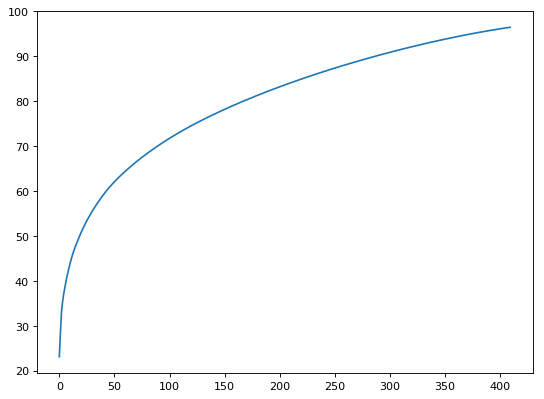

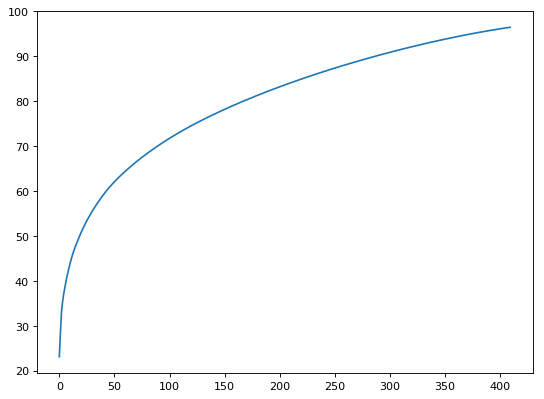

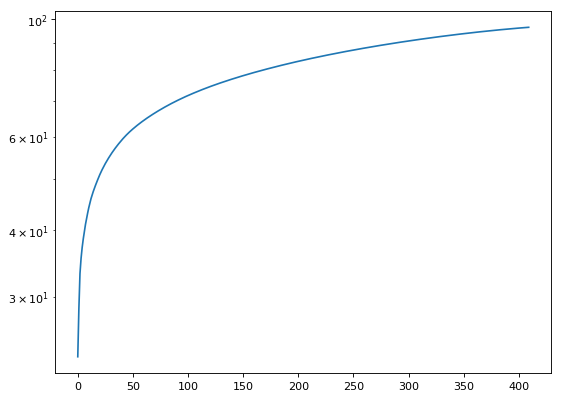

PCA finished for __test2__
(16614, 1572)
(16614, 2)
0
(1846, 1572)
(1846, 410)


/vol/biomedic/users/kgs13/.local/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


38.70156539714806
49.36907348122029
[[4.18503823e+00 8.50571238e+01]
 [2.29821934e+01 1.45983825e+01]
 [1.28399521e+01 2.59289811e+01]
 [1.46010229e+01 1.51672443e+02]
 [2.58200814e+01 1.06851074e+02]
 [2.48347979e+00 8.16961991e+01]
 [1.45045044e+01 2.53508158e+00]
 [5.94447399e+01 2.29893180e+02]
 [1.81700400e-01 3.10210388e+01]
 [8.26261802e+00 1.43568182e+02]
 [2.67016209e-02 1.99201293e+01]
 [6.79187567e+01 2.54253137e+01]
 [3.47826130e+01 6.26888195e+01]
 [2.70624036e+00 4.53751177e+00]
 [7.12572543e+00 3.13247402e+01]
 [1.48240361e+01 6.13888317e+01]
 [3.98936581e+01 3.28599645e+01]
 [1.27461737e+00 1.28834906e+01]
 [1.65175028e+01 3.04828100e+01]
 [8.22814992e+00 4.44496034e+01]
 [1.60792241e+01 2.26993928e+01]
 [1.23560768e+00 3.67803907e+01]
 [9.04664028e+00 5.73639271e+01]
 [1.07841253e+02 1.53639284e+02]
 [3.93501371e+01 3.29711474e+00]
 [9.28802569e+00 1.55473977e+02]
 [6.34861753e+00 3.62543643e+01]
 [3.30421931e+01 4.64915497e+01]
 [4.80038159e+01 5.62291103e+01]
 [4.208

/vol/biomedic/users/kgs13/.local/lib/python3.5/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide


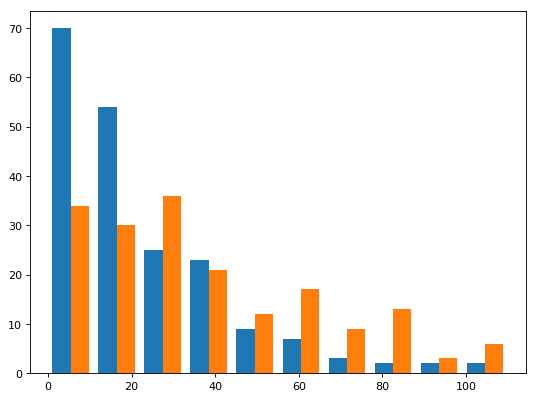

In [6]:
output_DM.data = np.asarray(output_DM.data)
input_DM.data = np.asarray(input_DM.data)
print(len(train_indices[0]))
print(len(test_indices[0]))
print(output_DM.data.shape)
tmp_test_data_new, tmp_pca = one_fold(input_DM.data[train_indices[0]], output_DM.data[train_indices[0]],input_DM.data[test_indices[0]], 
                          output_DM.data[test_indices[0]], name="__test2__")

In [7]:
print(len(tmp_test_data_new))
print(np.sum(tmp_pca.explained_variance_ratio_[0:405]))

1846
0.9625277057821169
